In [1]:
import numpy as np
import math
from scipy.integrate import quad
from scipy.linalg import eigvalsh
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
from itertools import product

In [2]:
#kronecker product code for more than 2 inputs
def kron(*matrices):
    result = np.array([[1]])
    for matrix in matrices:
        result = np.kron(result, matrix)
    return result

#Partial Trace Code
def IntegerDigits(n, b, l):
    digits = [0] * l
    pos = l - 1
    while pos != -1:
        digits[pos] = int(n % b)
        n //= b
        pos -= 1
    return digits

def FromDigits(digits, base):
    digits = digits[::-1]
    n = 0
    for i, d in enumerate(digits):
        n += d * base**i
        
    return n

def SwapParts(digits, p1, p2):
    new = np.copy(digits)
    new[p1] = digits[p2]
    new[p2] = digits[p1]
    return new

def dTraceSystem(D,s,dimen):
    Qudits=sorted(s)
    Qudits.reverse()
    TrkM = D
    z=len(Qudits)
    
    for q in range(z):
        n=math.log(TrkM.shape[0],dimen)
        assert n % 1 == 0
        n = int(n)
        
        M=TrkM
        M = np.array(M , dtype = complex)
        k=Qudits[q]
        temp = np.zeros(M.shape[0], dtype=complex)
        if k!=n:
            for j in range(n-k):
                b={0}
                for i in range(dimen**n):
                    digits=IntegerDigits(i,dimen,n)
                    if digits[n-1] != digits[n-j-2] and i not in  b:
                        number=FromDigits(
                            SwapParts(digits, n-1, n-j-2),
                            dimen
                        )
                        b.add(number)

                        temp[:] = M[i, :]
                        M[i, :] = M[number, :]
                        M[number, :] = temp

                        temp[:] = M[:, i]
                        M[:, i] = M[:, number]
                        M[:, number] = temp
        
        TrkM=[]
        for p in range(0,dimen**n,dimen):
            TrkM.append(
                sum(
                    M[p+h, h:dimen**n:dimen]
                    for h in range(dimen)
                )
            )
        TrkM = np.array(TrkM)
    
    return TrkM
#Recall matrix as dTraceSystem(matrix,[systems I want to trace out],dimension of system)


In [7]:
#defining basis vectors

#zero vector and its conjugate transpose                                         
zero= np.array([[1],[0]])
zeroCT=np.conjugate(zero.T)
#one vector and its conjugate transpose
one=np.array([[0],[1]])
oneCT=np.conjugate(one.T)
#plus vector and its conjugate transpose
plus=np.array([[1],[1]])*1/math.sqrt(2)
plusCT=np.conjugate(plus.T)
#minus vector and its conjugate transpose
minus=np.array([[1],[-1]])*1/math.sqrt(2)
minusCT=np.conjugate(minus.T)
#plusy and its conjugate transpose
plusy=np.array([[1],[complex(0.0, 1)]])*1/math.sqrt(2)
plusyCT=np.conjugate(plusy.T)
#minusy and its conjugate transpose
minusy=np.array([[1],[complex(0.0, -1)]])*1/math.sqrt(2)
minusyCT=np.conjugate(minusy.T)
#defining the Bell states
phiplus=(np.kron(zero, zero)+np.kron(one, one))*1/math.sqrt(2)
phiminus=(np.kron(zero, zero)-np.kron(one, one))*1/math.sqrt(2)
psiplus=(np.kron(zero, one)+np.kron(one, zero))*1/math.sqrt(2)
psiminus=(np.kron(zero, one)-np.kron(one, zero))*1/math.sqrt(2)
#defining the outer product of the Bell states
Phiplus=phiplus@np.conjugate(phiplus.T)
Phiminus=phiminus@np.conjugate(phiminus.T)
Psiplus=psiplus@np.conjugate(psiplus.T)
Psiminus=psiminus@np.conjugate(psiminus.T)
#defining Pauli matrices
pauliX=np.array([[0,1],[1,0]])
pauliY=np.array([[0,complex(0,-1)],[complex(0,1),0]])
pauliZ=np.array([[1,0],[0,-1]])

In [8]:
def r(p, q):
    return np.array([
        p[3]*q[0] + p[2]*q[1] + p[1]*q[2] + p[0]*q[3],
        p[2]*q[0] + p[3]*q[1] + p[0]*q[2] + p[1]*q[3],
        p[1]*q[0] + p[0]*q[1] + p[3]*q[2] + p[2]*q[3],
        p[0]*q[0] + p[1]*q[1] + p[2]*q[2] + p[3]*q[3]
    ])

def rNtimes(p, n):
    if n == 1:
        return r(p, p)
    else:
        return r(rNtimes(p, n-1), p)

In [9]:
#Defining parameters for GKP states

#Quality of GKP state
def sigmaloss(sigma , eta):
    return np.sqrt(eta*sigma**2 + (1-eta))

#Error functions
def f(x , mu , sigma , eta):
    s = sigmaloss(sigma , eta)
    return np.exp(-(x - mu)**2 / (2 * s**2))/(s * np.sqrt(2*np.pi))
def Pc(sigma , nu , eta):
    integrand = lambda x: f(x , 0 , sigma , eta)
    lower = -0.5 * np.sqrt(np.pi) + nu
    upper =  0.5 * np.sqrt(np.pi) - nu
    return quad(integrand, lower, upper)[0] 
    
def Pf(sigma , nu , eta):
    integrand = lambda x: f(x, 0, sigma, eta)
    lower = 0.5 * np.sqrt(np.pi) + nu
    upper = 1.5 * np.sqrt(np.pi) - nu
    return 2 * quad(integrand, lower, upper)[0]

#Bell state mixture probabilities
def p1(sigma , nu , eta):
    pc = Pc(sigma , nu , eta)
    pf = Pf(sigma , nu , eta)
    return (pc**2) / (pc + pf)**2
def p2(sigma , nu , eta):
    pc = Pc(sigma , nu , eta)
    pf = Pf(sigma , nu , eta)
    return (pc * pf) / (pc + pf)**2
def p3(sigma , nu , eta):
    pc = Pc(sigma , nu , eta)
    pf = Pf(sigma , nu , eta)
    return (pf**2) / (pc + pf)**2
#Mixture of Bell states
def new_vector(sigma , nu , eta):
    return np.array([
        p1(sigma , nu , eta) , 
        p2(sigma , nu , eta) , 
        p2(sigma , nu , eta) , 
        p3(sigma , nu , eta)
        ])

#von Neumann entropy
def vonneumann(mat):
    evals = eigvalsh(mat)
    evals = np.clip(evals, 1e-16 , 1)
    return -np.sum(evals * np.log2(evals))

# hashing bound
def hashing_bound(mat):
    sAB = vonneumann(mat)
    sA = vonneumann(dTraceSystem(mat , [2] , 2))
    sB = vonneumann(dTraceSystem(mat , [1] , 2))
    return max(sA - sAB , sB - sAB)

# chain function
def chain_function(vec , n):
    return rNtimes(vec , n)

# building the chain states
def BSM_mixture_chain(vec):
    return vec[0] * Phiplus + vec[1] * Phiminus + vec[2] * Psiplus + vec[3] * Psiminus
 

In [76]:
# 2:1 distillation scheme

# rotation of Pauli X
Xrotation1 = np.cos(np.pi / 4)*np.identity(2) - 1j*np.sin(np.pi / 4)*pauliX
Xrotation2 = np.cos(-np.pi / 4)*np.identity(2) - 1j*np.sin(-np.pi / 4)*pauliX
Xrotation4 = kron(Xrotation1 , Xrotation2 , Xrotation1 , Xrotation2)

# CNOT gate
CNOT = kron(zero @ zeroCT , zero @ zeroCT , np.identity(4)) + kron(one @ oneCT , one @ oneCT , pauliX , pauliX) + kron(zero @ zeroCT , one @ oneCT , np.identity(2) , pauliX) + kron(one @ oneCT , zero @ zeroCT , pauliX , np.identity(2))

# measurement in Z
# both qubits must match
p00 = kron(np.identity(4) , zero @ zeroCT , zero @ zeroCT)
p11 = kron(np.identity(4) , one @ oneCT , one @ oneCT)

# procedure
def input_state(vec):
    return kron(vec , vec)
def CNOT_rotated(vec):
    state = input_state(vec)
    return CNOT @ Xrotation4 @ state @ np.conjugate(Xrotation4.T) @ np.conjugate(CNOT.T)

# Post-Selection

# Generate indices for all 4-qubit basis states
StateVectors = np.array(list(product([0, 1], repeat=4)))
# Select basis states where qubits 3 and 4 are either both 0 or both 1
Patt00 = [i for i, v in enumerate(StateVectors) if (v[2] == 0 and v[3] == 0)]

# Redefined successful distillation with post-selection
def successful_distillation_with_post_selection(vec):
    state = CNOT_rotated(vec)

    full_projected = p00 @ state @ np.conjugate(p00.T) + p11 @ state @ np.conjugate(p11.T)

    selector = np.array(Patt00)
    post_selected = full_projected[np.ix_(selector, selector)]
    tr = np.trace(post_selected)

    true_post_selected = post_selected/tr
    
    # if np.abs(tr) < 1e-12 or not np.isfinite(tr):
    #     return np.zeros_like(true_post_selected)
    
  
    return true_post_selected



# performing n rounds of distillation
def n_round_distillation(vec, N):

    rho = vec
    # last_successful_rho = vec.copy()

    # bell_states = [Phiplus , Phiminus , Psiplus , Psiminus]

    for i in range(N):
        rho = successful_distillation_with_post_selection(rho)

        # if np.allclose(rho , 0) or not np.isfinite(np.trace(rho)):
        #     print(f"Distillation failed at round {i+1} (zero or invalid)")
        #     return last_successful_rho
        
        # if any(np.array_equal(rho , bell) for bell in bell_states):
        #     print(f"Distillation failed at round {i + 1} (collapsed to Bell State)")
        #     last_successful_rho = rho.copy()
            
        # else:
        #     last_successful_rho = rho.copy()
    
    return rho

In [78]:
# distillation of GKP states
def distilled_GKP_chain(sigma , nu , eta , n , N):
    BellState_weights = chain_function(new_vector(sigma , nu , eta) , n)
    state = BSM_mixture_chain(BellState_weights)
    return n_round_distillation(state , N)


# hashing bound of GKP states
def GKP_hashing_bound(sigma , nu , eta , n , N):
    vec = distilled_GKP_chain(sigma , nu , eta , n , N)
    return hashing_bound(vec)


# hashing rate
def hashing_rate(sigma , nu , eta , n , N):
    pc = Pc(sigma , nu , eta)
    pf = Pf(sigma , nu , eta)
    PsuccGKP = (pc + pf)**2
    vec = distilled_GKP_chain(sigma , nu , eta , n , N)
    return (PsuccGKP/(2**N)) * hashing_bound(vec)


# optimal hashing bound
def optimal_hashing_bound(sigma , eta , n , N , return_nu = False):
    def neg_bound(nu):
        try:
            value = GKP_hashing_bound(sigma , nu , eta , n , N)
            return -value if value > 0 else np.inf
        except Exception:
            return np.inf

    result = minimize_scalar(neg_bound, bounds=(0, 0.5 * np.sqrt(np.pi)), method='bounded')
    bound = -result.fun

    if not np.isfinite(bound) or bound <= 0:
        bound = 0.0

    if return_nu:
        return bound , result.x  # return rate, ν
    return bound

# optimal hashing rate
def optimal_hashing_rate(sigma , eta , n , N , return_nu = False):
    def neg_rate(nu):
        try:
            value = hashing_rate(sigma , nu , eta , n , N)
            return -value if value > 0 else np.inf
        except Exception:
            return np.inf

    result = minimize_scalar(neg_rate, bounds=(0, 0.5 * np.sqrt(np.pi)), method='bounded')
    rate = -result.fun

    if not np.isfinite(rate) or rate <= 0:
        rate = 0.0

    if return_nu:
        return rate , result.x  # return rate, ν
    return rate

In [101]:
QStateSingle(0.1 , 0.5 , 0 , 1)

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.29695228, 0.29695228, 0.        ],
       [0.        , 0.29695228, 0.29695228, 0.        ],
       [0.        , 0.        , 0.        , 0.40609544]])

In [92]:
# Single Rail

def SingleRailState(eta , gamma , Pd , Vis):
    return 2 * np.array(
        [
            [(1 - Pd)*Pd*gamma**2, 0 , 0 , 0], 
            [0 , (1 - Pd) * Pd * (1 - gamma) * gamma * (1 - np.sqrt(eta)) + 1/2 * ((1 - Pd)**2) * (1 - gamma) * gamma * np.sqrt(eta) , 1/2 * ((1 - Pd)**2) * (1 - gamma) * gamma * np.sqrt(eta)* Vis , 0] ,
            [0 , 1/2 * ((1 - Pd)**2) * (1 - gamma) * gamma * np.sqrt(eta) * Vis , (1 - Pd)* Pd * (1 - gamma) * gamma * (1 - np.sqrt(eta)) + 1/2 * ((1 - Pd)**2) * (1 - gamma) * gamma * np.sqrt(eta), 0] ,
            [0 , 0 , 0, (1 - Pd) * Pd * ((1 - gamma)**2) * ((1 - np.sqrt(eta))**2) + ((1 - Pd)**2) * ((1 - gamma)**2) * (1 - np.sqrt(eta)) * np.sqrt(eta)]
        ]
    )
# normalised quantum state for single-rail entangled memory pair
def QStateSingle(eta , gamma , Pd , Vis):
    state = SingleRailState(eta , gamma , Pd , Vis)
    tr = np.trace(state)
    # avoiding division by 0
    if tr == 0 or not np.isfinite(tr):
        return np.zeros_like(state)
    return state / tr

# Building chains of SR encoded states

def SRinitialState(eta , gamma):
    BSM = kron(np.identity(2) , Phiplus , np.identity(2))
    rho = kron(QStateSingle(eta , gamma , 1e-2 , 1) , QStateSingle(eta , gamma , 1e-2 , 1))
    rho = BSM @ rho @ np.conjugate(BSM.T)
    rho = rho / np.trace(rho)
    return dTraceSystem(rho , [2 , 3] , 2)

def SRextendState(rho , eta , gamma):
    BSM = kron(np.identity(2) , Phiplus , np.identity(2))
    rho_ext = kron(rho , QStateSingle(eta , gamma , 1e-2 , 1))
    rho_ext = BSM @ rho_ext @ np.conjugate(BSM.T)
    rho_ext = rho_ext / np.trace(rho_ext)
    return dTraceSystem(rho_ext , [2 , 3] , 2)

def SRchainState(eta , gamma , n):
    if n == 1:
        return QStateSingle(eta , gamma , 1e-2 , 1)
    rho = SRinitialState(eta , gamma)
    for _ in range(n - 2):
        rho = SRextendState(rho , eta , gamma)
    return rho

# Single-Rail Hashing bound
def SRhashing_bound(eta , gamma , n , N):
    rho = n_round_distillation(SRchainState(eta , gamma , n) , N)
    return hashing_bound(rho)

# Single-Rail Hashing Rate
def SRhashingrate(eta , gamma , n , N):
    PsuccSR = np.trace(SingleRailState(eta , gamma , 1e-2 , 1))
    rho = n_round_distillation(SRchainState(eta , gamma , n) , N)
    return (PsuccSR / (2**N)) * hashing_bound(rho)

# optimal hashing bound
def optimal_SRhashingbound(eta , n , N):
    gammas = np.linspace(0, 1, 100)
    bounds = []
    for gamma in gammas:
        # try:
        bound = SRhashing_bound(eta, gamma, n , N)
        # ensuring that the hashing rate is a valid number
        if not np.isnan(bound) and not np.isinf(bound):
            bounds.append(bound)
        # except Exception as e:
        #     # print(f"Skipping gamma = {gamma}: {e}")
        #     continue
    return max(bounds) if bounds else 0

# optimising over gamma
def optimal_SRhashingrate(eta , n , N):
    gammas = np.linspace(0, 1, 100)
    rates = []
    for gamma in gammas:
        try:
            rate = SRhashingrate(eta, gamma, n , N)
            # ensuring that the hashing rate is a valid number
            if not np.isnan(rate) and not np.isinf(rate):
                rates.append(rate)
        except Exception as e:
            # print(f"Skipping gamma = {gamma}: {e}")
            continue
    return max(rates) if rates else 0

In [93]:
# Dual Rail
def DualRailState(eta , Pd , Vis):
    return 4 * np.array(
        [
            [1/4 * ((1 - Pd)**2) * (Pd**2) * (1 - np.sqrt(eta))**2 + 1/4 * ((1 - Pd)**3) * Pd * (1 - np.sqrt(eta)) * np.sqrt(eta), 0 , 0 , 0] ,
            [0 , 1/4 * ((1 - Pd)**2) * (Pd**2) * (1 - np.sqrt(eta))**2 + 1/4 * ((1 - Pd)**3) * Pd * (1 - np.sqrt(eta)) * np.sqrt(eta) + 1/16 * ((1 - Pd)**4) * eta , 1/16 * ((1 - Pd)**4) * eta * Vis**2 , 0] ,
            [0 , 1/16 * ((1 - Pd)**4) *eta * Vis**2 , 1/4 * ((1 - Pd)**2) * (Pd**2) * (1 - np.sqrt(eta))**2 + 1/4 * ((1 - Pd)**3) * Pd * (1 - np.sqrt(eta)) * np.sqrt(eta) + 1/16 * ((1 - Pd)**4) * eta , 0] ,
            [0 , 0 , 0 , 1/4 * ((1 - Pd)**2) * (Pd**2) * (1 - np.sqrt(eta))**2 + 1/4 * ((1 - Pd)**3) * Pd * (1 - np.sqrt(eta)) * np.sqrt(eta)]
        ]
    )
# normalised quantum state for dual-rail entangled memory pair
def QStateDual(eta , Pd , Vis):
    state = DualRailState(eta , Pd , Vis)
    tr = np.trace(DualRailState(eta , Pd , Vis))
    # avoiding division by 0
    if tr == 0 or not np.isfinite(tr):
        return np.zeros_like(state)
    return state / tr

def DR_hashing_bound(eta , n , N):

    if n == 1:
        state = n_round_distillation(QStateDual(eta , 1e-2 , 1) , N)
        # if not np.isfinite(state).all():
        #     return 0
        # return max(0.0 , hashing_bound(state))
        return hashing_bound(state)
    
    else:
        vec = rNtimes(np.linalg.eigvalsh(QStateDual(eta , 1e-2 , 1)) , n - 1)
        rho = BSM_mixture_chain(vec)
        state = n_round_distillation(rho , N)
        # return max(0.0 , hashing_bound(state))
        return hashing_bound(state)

# hashing rate
def DRhashingrate(eta , n , N):
    
    PsuccDR = np.trace(DualRailState(eta , 1e-2 , 1))
    
    if n == 1:
        state = n_round_distillation(QStateDual(eta , 1e-2 , 1) , N)
        if not np.isfinite(state).all():
            return 0
        return (PsuccDR / (2**N)) * hashing_bound(state)
    else:
        vec = rNtimes(np.linalg.eigvalsh(QStateDual(eta , 1e-2 , 1)) , n - 1)
        rho = BSM_mixture_chain(vec)
        state = n_round_distillation(rho , N)
        return (PsuccDR / 2**N) * hashing_bound(state)

In [70]:
def partial_transpose(input_matrix, dim_1, dim_2, subsystem):
    assert input_matrix.shape == (4, 4)
    assert dim_1 == 2
    assert dim_2 == 2
    assert subsystem in (1, 2)
    
    im = input_matrix
    
    if subsystem == 1:
        return np.array([
            [im[0, 0], im[0, 1], im[2, 0], im[2, 1]],
            [im[1, 0], im[1, 1], im[3, 0], im[3, 1]],
            [im[0, 2], im[0, 3], im[2, 2], im[2, 3]],
            [im[1, 2], im[1, 3], im[3, 2], im[3, 3]],
        ])
    elif subsystem == 2:
        return np.array([
            [im[0, 0], im[1, 0], im[0, 2], im[1, 2]],
            [im[0, 1], im[1, 1], im[0, 3], im[1, 3]],
            [im[2, 0], im[3, 0], im[2, 2], im[3, 2]],
            [im[2, 1], im[3, 1], im[2, 3], im[3, 3]],
        ])
def eigenvalues1(rho):

    return np.real(
        np.linalg.eigvals(
            partial_transpose(
                rho,
                2,
                2,
                1,
            )
        )
    )
#defining the negativity function
def negativity1(p):
    eigenvalues = eigenvalues1(p)
    return np.sum((np.abs(eigenvalues) - eigenvalues) / 2)

In [73]:
negativity1(QStateDual(0.8,1e-2,1))

0.4929056433452307

In [77]:
n_round_distillation(QStateDual(0.8,1e-2,1) , 1)

array([[ 1.12907168e-05+0.j, -4.38230061e-20+0.j,  4.45712037e-20+0.j,
        -1.12800456e-20+0.j],
       [ 5.93876439e-19+0.j,  4.99988709e-01+0.j,  4.95248061e-01+0.j,
        -7.19922843e-19+0.j],
       [ 1.34218323e-17+0.j,  4.95248061e-01+0.j,  4.99988709e-01+0.j,
         1.47348481e-17+0.j],
       [-1.13511148e-20+0.j, -4.38230061e-20+0.j,  4.42505476e-20+0.j,
         1.12907168e-05+0.j]])

In [63]:
sigma1 = np.sqrt(0.01)
n = 1
etas = np.linspace(0.01, 1.0, 100)

# Precompute all rates
ratesGKP1 = [
    [optimal_hashing_rate(sigma1, eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]

ratesSR1 = [
    [optimal_SRhashingrate(eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]

ratesDR1 = [
    [DRhashingrate(eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]


/Users/conallcampbell/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2307: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/Users/conallcampbell/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2308: RuntimeWarning: invalid value encountered in scalar subtract
  q = 2.0 * (q - r)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_61959/103485639.py:40: RuntimeWarning: invalid value encountered in divide
  true_post_selected = post_selected/tr


Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)


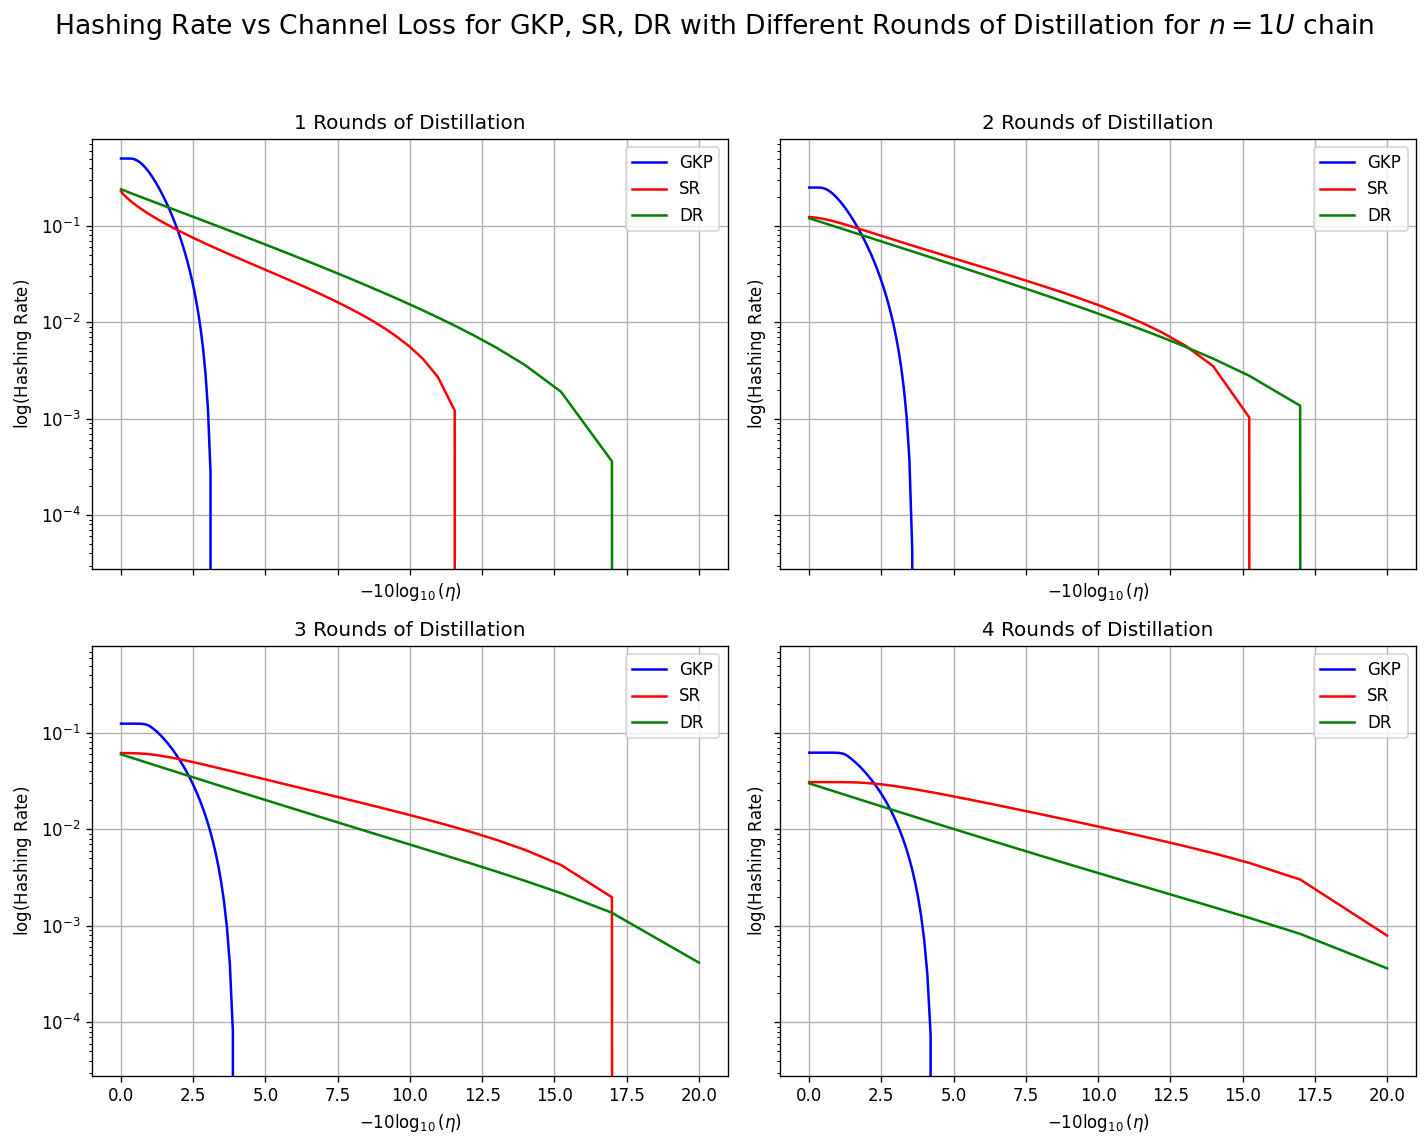

In [64]:
# Setup subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10), dpi=120, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.3)

Ns = [1, 2, 3, 4]
dB = -10 * np.log10(etas)
for i, ax in enumerate(axs.flat):
    N = Ns[i]
    ax.set_yscale("log")
    ax.plot(dB, ratesGKP1[i] , label="GKP", color="blue")
    ax.plot(dB, ratesSR1[i] , label="SR", color="red")
    ax.plot(dB, ratesDR1[i] , label="DR", color="green")
    ax.set_title(f"{N} Rounds of Distillation")
    ax.set_xlabel(r"$-10\log_{10}(\eta)$")
    ax.set_ylabel(r"$\log(\text{Hashing Rate})$")
    ax.grid(True)
    ax.legend()
    

fig.suptitle("Hashing Rate vs Channel Loss for GKP, SR, DR with Different Rounds of Distillation for $n=1U$ chain" , fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



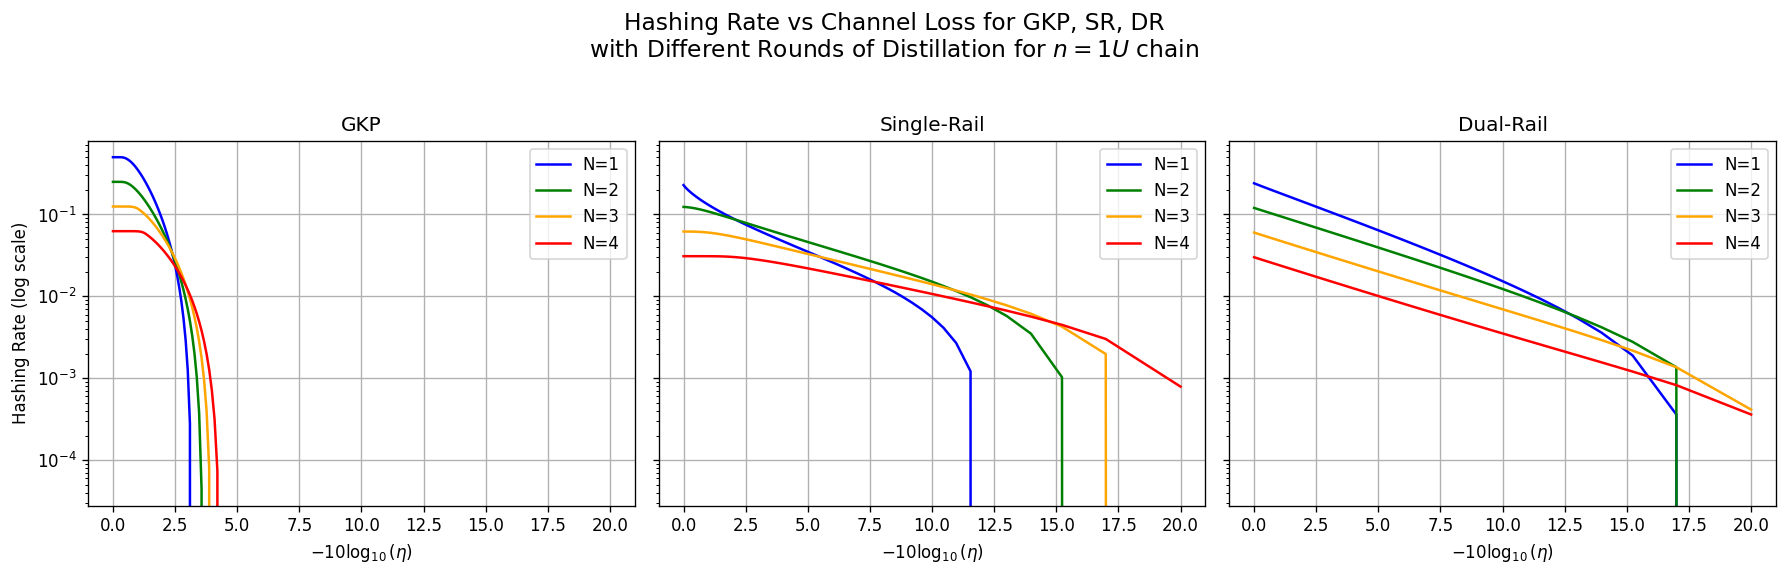

In [65]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=120, sharex=True, sharey=True)
titles = ['GKP', 'Single-Rail', 'Dual-Rail']
all_rates = [ratesGKP1, ratesSR1, ratesDR1]
colors = ['blue', 'green', 'orange', 'red']
Ns = [1, 2, 3, 4]

for ax, rates, title in zip(axs, all_rates, titles):
    ax.set_yscale("log")
    for i, N in enumerate(Ns):
        ax.plot(dB, rates[i], label=f"N={N}", color=colors[i])
    ax.set_title(title)
    ax.set_xlabel(r"$-10\log_{10}(\eta)$")
    ax.grid(True)
    ax.legend()

axs[0].set_ylabel("Hashing Rate (log scale)")

fig.suptitle("Hashing Rate vs Channel Loss for GKP, SR, DR\nwith Different Rounds of Distillation for $n=1U$ chain", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [31]:
sigma1 = np.sqrt(0.01)
n = 4
etas = np.linspace(0.01, 1.0, 100)

# Precompute all rates
ratesGKP4 = [
    [optimal_hashing_rate(sigma1, eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]
ratesSR4 = [
    [optimal_SRhashingrate(eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]
ratesDR4 = [
    [DRhashingrate(eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]

/Users/conallcampbell/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2307: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/Users/conallcampbell/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2308: RuntimeWarning: invalid value encountered in scalar subtract
  q = 2.0 * (q - r)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_61959/2958108536.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)


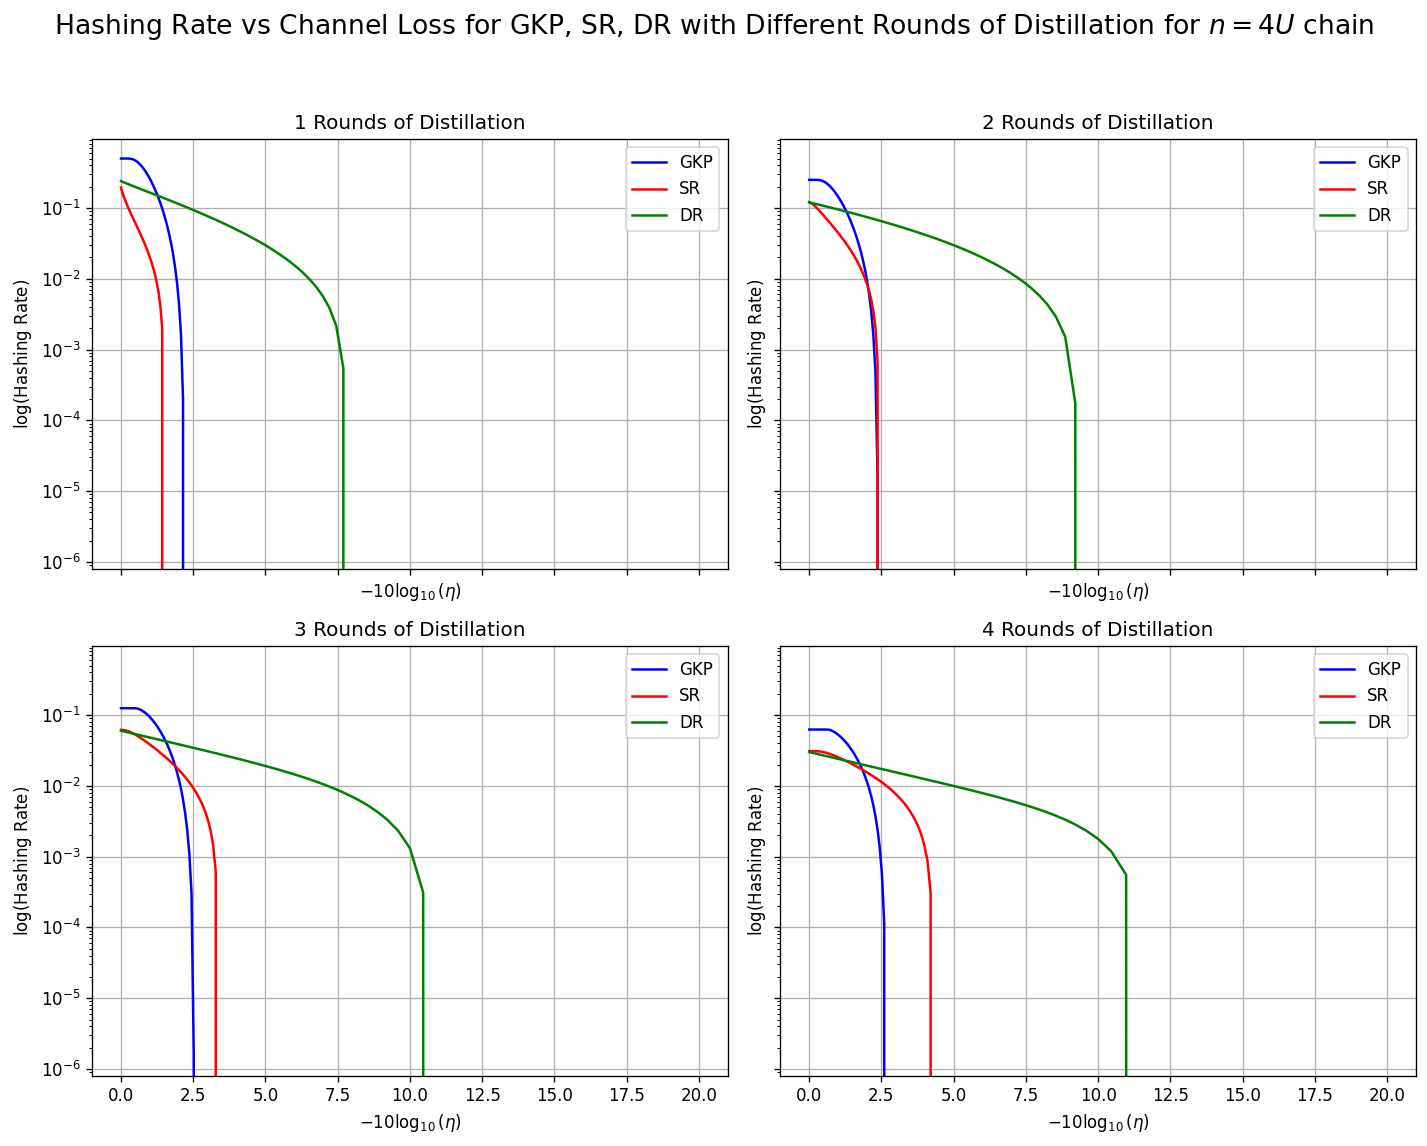

In [32]:
# Setup subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10), dpi=120, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.3)

Ns = [1, 2, 3, 4]
dB = -10 * np.log10(etas)
for i, ax in enumerate(axs.flat):
    N = Ns[i]
    ax.set_yscale("log")
    ax.plot(dB, ratesGKP4[i] , label="GKP", color="blue")
    ax.plot(dB, ratesSR4[i] , label="SR", color="red")
    ax.plot(dB, ratesDR4[i] , label="DR", color="green")
    ax.set_title(f"{N} Rounds of Distillation")
    ax.set_xlabel(r"$-10\log_{10}(\eta)$")
    ax.set_ylabel(r"$\log(\text{Hashing Rate})$")
    ax.grid(True)
    ax.legend()
    

fig.suptitle("Hashing Rate vs Channel Loss for GKP, SR, DR with Different Rounds of Distillation for $n=4U$ chain" , fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


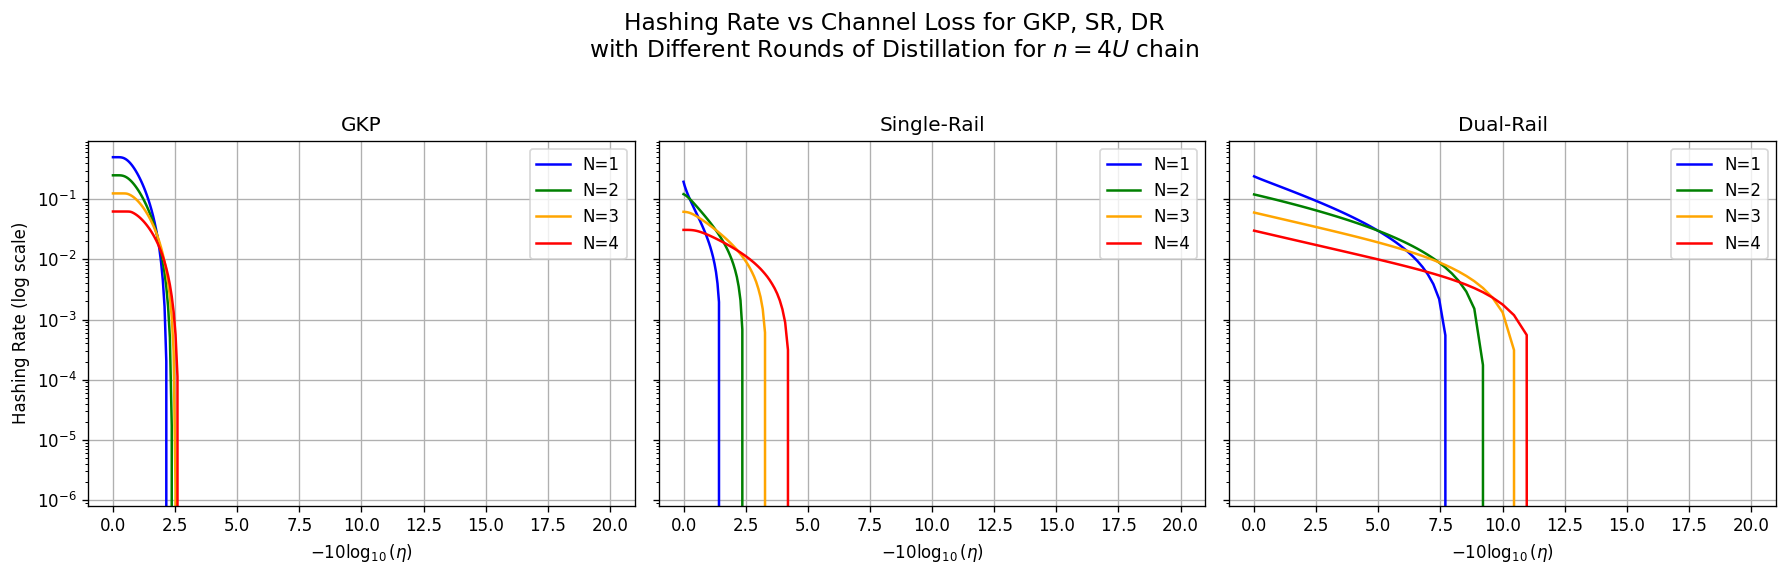

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=120, sharex=True, sharey=True)
titles = ['GKP', 'Single-Rail', 'Dual-Rail']
all_rates = [ratesGKP4, ratesSR4, ratesDR4]
colors = ['blue', 'green', 'orange', 'red']
Ns = [1, 2, 3, 4]

for ax, rates, title in zip(axs, all_rates, titles):
    ax.set_yscale("log")
    for i, N in enumerate(Ns):
        ax.plot(dB, rates[i], label=f"N={N}", color=colors[i])
    ax.set_title(title)
    ax.set_xlabel(r"$-10\log_{10}(\eta)$")
    ax.grid(True)
    ax.legend()

axs[0].set_ylabel("Hashing Rate (log scale)")

fig.suptitle("Hashing Rate vs Channel Loss for GKP, SR, DR\nwith Different Rounds of Distillation for $n=4U$ chain", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [34]:
sigma1 = np.sqrt(0.01)
n = 10
etas = np.linspace(0.01, 1.0, 100)

# Precompute all rates
ratesGKP10 = [
    [optimal_hashing_rate(sigma1, eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]
ratesSR10 = [
    [optimal_SRhashingrate(eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]
ratesDR10 = [
    [DRhashingrate(eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]

/Users/conallcampbell/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2307: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/Users/conallcampbell/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2308: RuntimeWarning: invalid value encountered in scalar subtract
  q = 2.0 * (q - r)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_61959/2958108536.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)


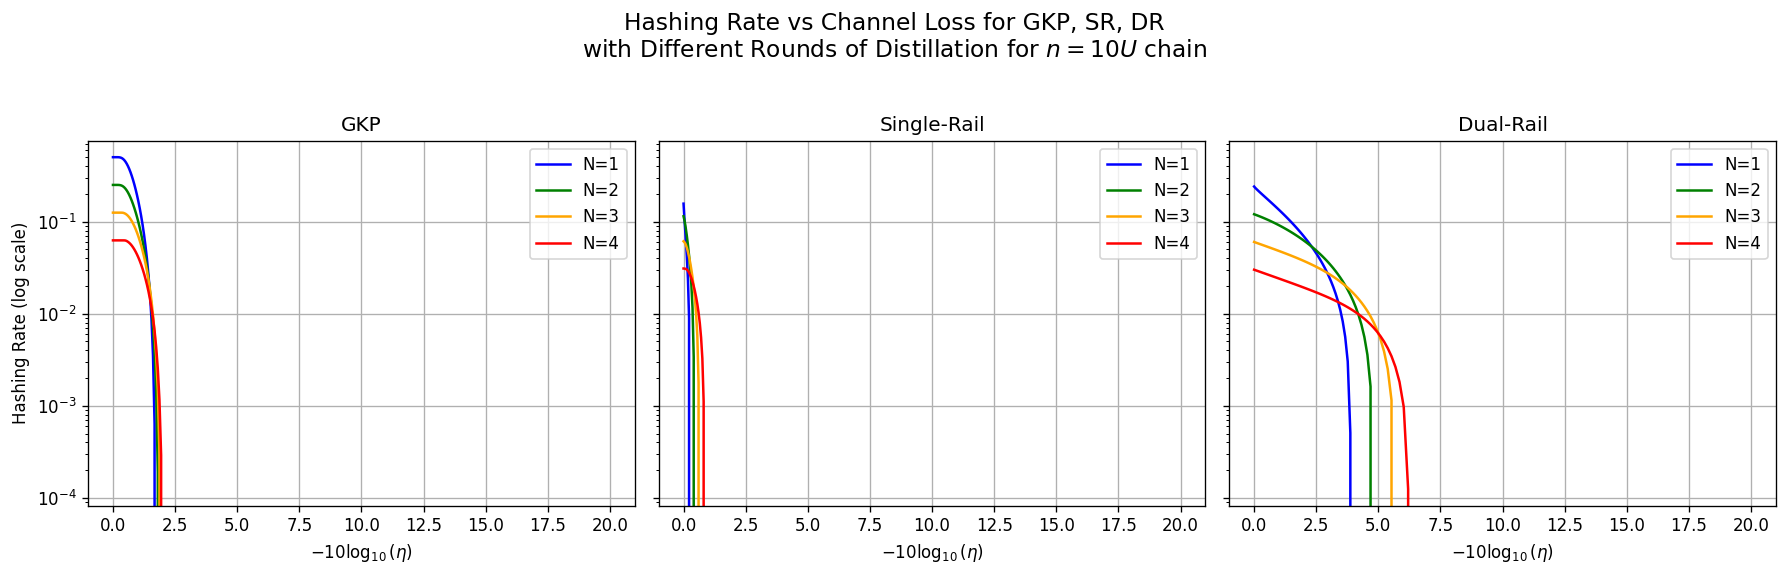

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=120, sharex=True, sharey=True)
titles = ['GKP', 'Single-Rail', 'Dual-Rail']
all_rates = [ratesGKP10, ratesSR10, ratesDR10]
colors = ['blue', 'green', 'orange', 'red']
Ns = [1, 2, 3, 4]

for ax, rates, title in zip(axs, all_rates, titles):
    ax.set_yscale("log")
    for i, N in enumerate(Ns):
        ax.plot(dB, rates[i], label=f"N={N}", color=colors[i])
    ax.set_title(title)
    ax.set_xlabel(r"$-10\log_{10}(\eta)$")
    ax.grid(True)
    ax.legend()

axs[0].set_ylabel("Hashing Rate (log scale)")

fig.suptitle("Hashing Rate vs Channel Loss for GKP, SR, DR\nwith Different Rounds of Distillation for $n=10U$ chain", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [36]:
sigma1 = np.sqrt(0.01)
n = 50
etas = np.linspace(0.01, 1.0, 100)

# Precompute all rates
ratesGKP50 = [
    [optimal_hashing_rate(sigma1, eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]
ratesSR50 = [
    [optimal_SRhashingrate(eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]
ratesDR50 = [
    [DRhashingrate(eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]

/Users/conallcampbell/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2307: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/Users/conallcampbell/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2308: RuntimeWarning: invalid value encountered in scalar subtract
  q = 2.0 * (q - r)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_61959/2958108536.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)


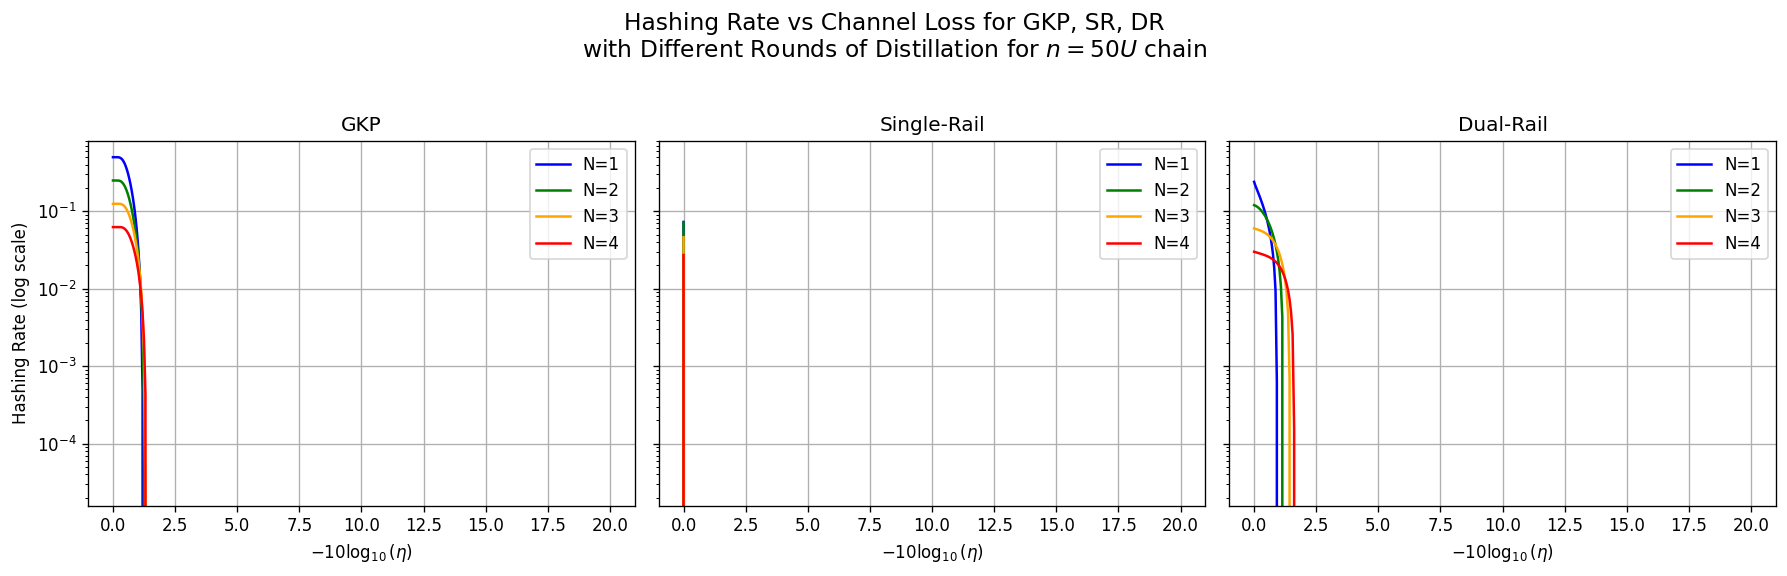

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=120, sharex=True, sharey=True)
titles = ['GKP', 'Single-Rail', 'Dual-Rail']
all_rates = [ratesGKP50, ratesSR50, ratesDR50]
colors = ['blue', 'green', 'orange', 'red']
Ns = [1, 2, 3, 4]

for ax, rates, title in zip(axs, all_rates, titles):
    ax.set_yscale("log")
    for i, N in enumerate(Ns):
        ax.plot(dB, rates[i], label=f"N={N}", color=colors[i])
    ax.set_title(title)
    ax.set_xlabel(r"$-10\log_{10}(\eta)$")
    ax.grid(True)
    ax.legend()

axs[0].set_ylabel("Hashing Rate (log scale)")

fig.suptitle("Hashing Rate vs Channel Loss for GKP, SR, DR\nwith Different Rounds of Distillation for $n=50U$ chain", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [38]:
sigma1 = np.sqrt(0.01)
n = 100
etas = np.linspace(0.01, 1.0, 100)

# Precompute all rates
ratesGKP100 = [
    [optimal_hashing_rate(sigma1, eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]
ratesSR100 = [
    [optimal_SRhashingrate(eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]
ratesDR100 = [
    [DRhashingrate(eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_61959/2958108536.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)


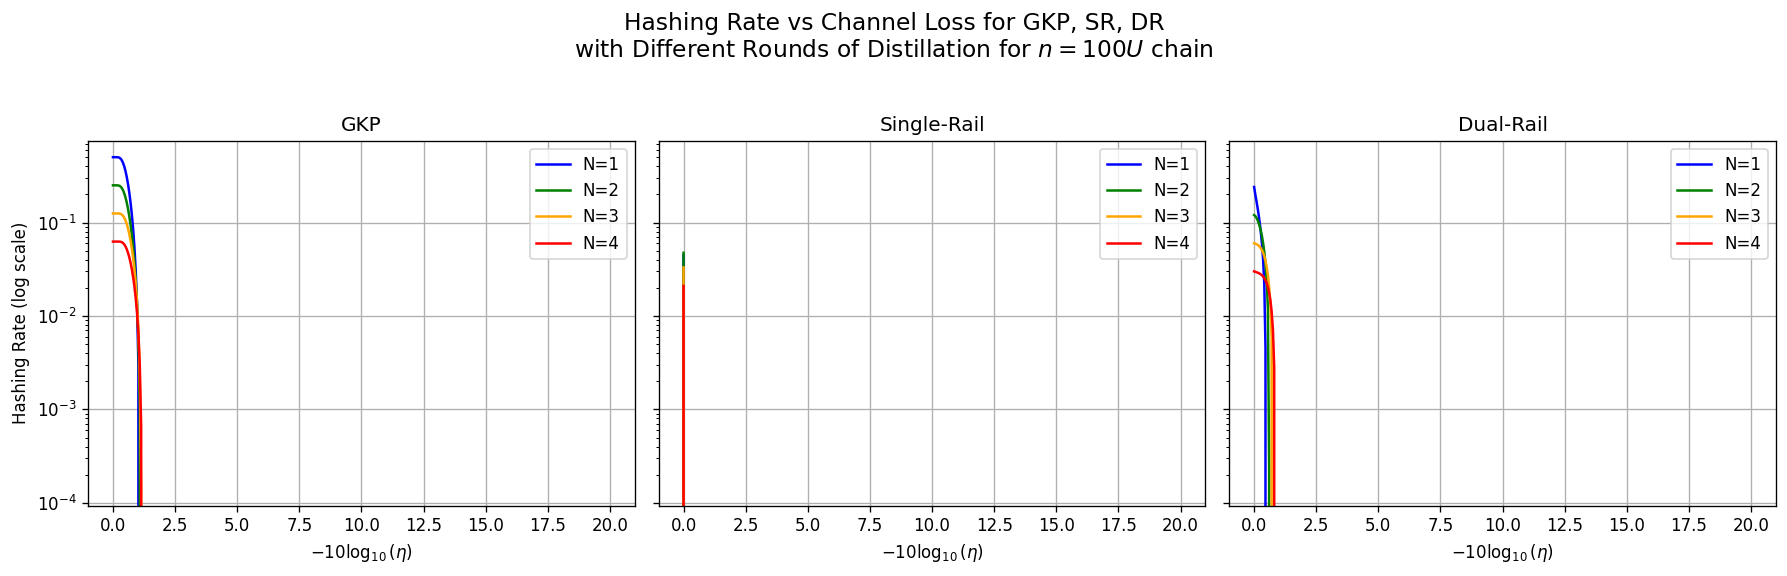

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=120, sharex=True, sharey=True)
titles = ['GKP', 'Single-Rail', 'Dual-Rail']
all_rates = [ratesGKP100, ratesSR100, ratesDR100]
colors = ['blue', 'green', 'orange', 'red']
Ns = [1, 2, 3, 4]

for ax, rates, title in zip(axs, all_rates, titles):
    ax.set_yscale("log")
    for i, N in enumerate(Ns):
        ax.plot(dB, rates[i], label=f"N={N}", color=colors[i])
    ax.set_title(title)
    ax.set_xlabel(r"$-10\log_{10}(\eta)$")
    ax.grid(True)
    ax.legend()

axs[0].set_ylabel("Hashing Rate (log scale)")

fig.suptitle("Hashing Rate vs Channel Loss for GKP, SR, DR\nwith Different Rounds of Distillation for $n=100U$ chain", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [40]:
sigma1 = np.sqrt(0.01)
n = 200
etas = np.linspace(0.01, 1.0, 100)

# Precompute all rates
ratesGKP200 = [
    [optimal_hashing_rate(sigma1, eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]
ratesSR200 = [
    [optimal_SRhashingrate(eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]
ratesDR200 = [
    [DRhashingrate(eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_61959/2958108536.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)


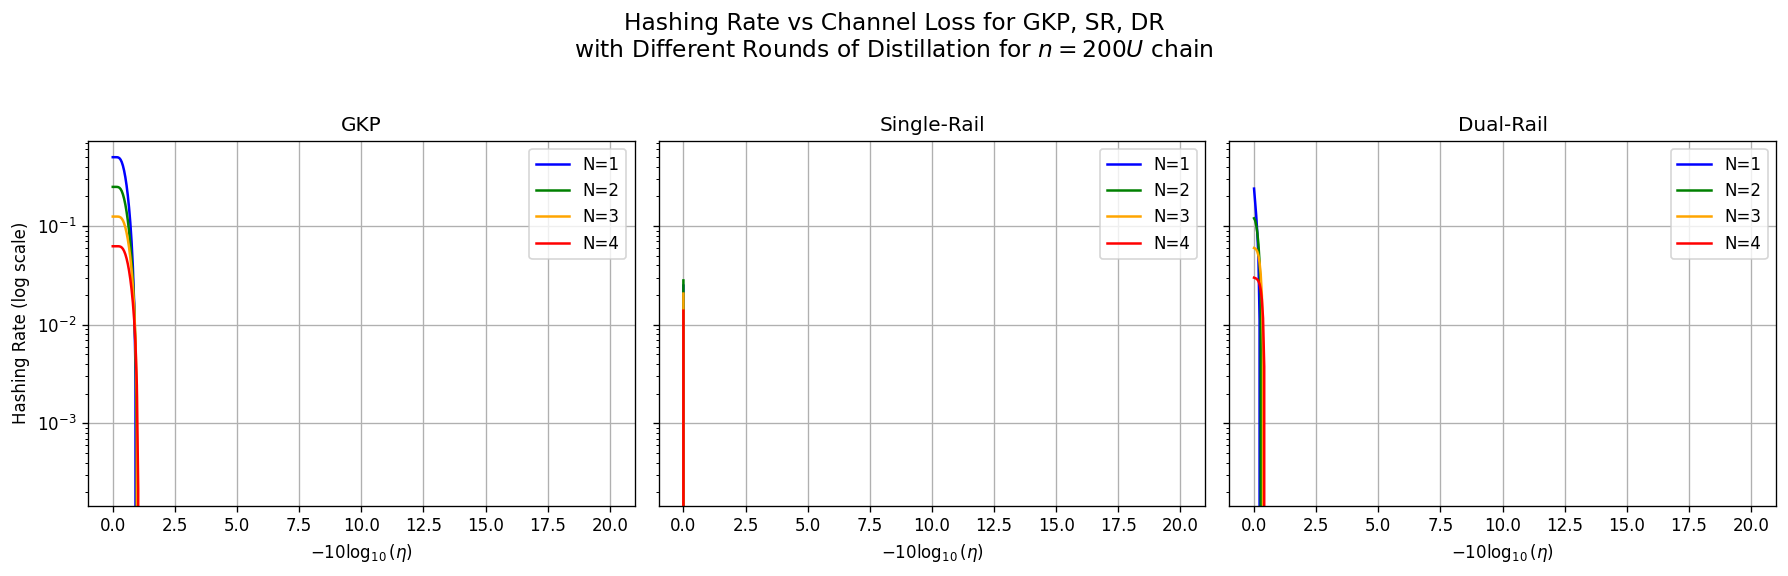

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=120, sharex=True, sharey=True)
titles = ['GKP', 'Single-Rail', 'Dual-Rail']
all_rates = [ratesGKP200, ratesSR200, ratesDR200]
colors = ['blue', 'green', 'orange', 'red']
Ns = [1, 2, 3, 4]

for ax, rates, title in zip(axs, all_rates, titles):
    ax.set_yscale("log")
    for i, N in enumerate(Ns):
        ax.plot(dB, rates[i], label=f"N={N}", color=colors[i])
    ax.set_title(title)
    ax.set_xlabel(r"$-10\log_{10}(\eta)$")
    ax.grid(True)
    ax.legend()

axs[0].set_ylabel("Hashing Rate (log scale)")

fig.suptitle("Hashing Rate vs Channel Loss for GKP, SR, DR\nwith Different Rounds of Distillation for $n=200U$ chain", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [94]:

sigma1 = np.sqrt(0.01)
n = 1
etas = np.logspace(-3 , 0 , 100)

# Precompute all bounds
boundsGKP1 = [
    [optimal_hashing_bound(sigma1, eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4 , 5]
]

boundsSR1 = [
    [optimal_SRhashingbound(eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4 , 5]
]

boundsDR1 = [
    [DR_hashing_bound(eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4 , 5]
]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2307: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2308: RuntimeWarning: invalid value encountered in scalar subtract
  q = 2.0 * (q - r)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_68574/458387683.py:40: RuntimeWarning: invalid value encountered in divide
  true_post_selected = post_selected/tr


ValueError: array must not contain infs or NaNs

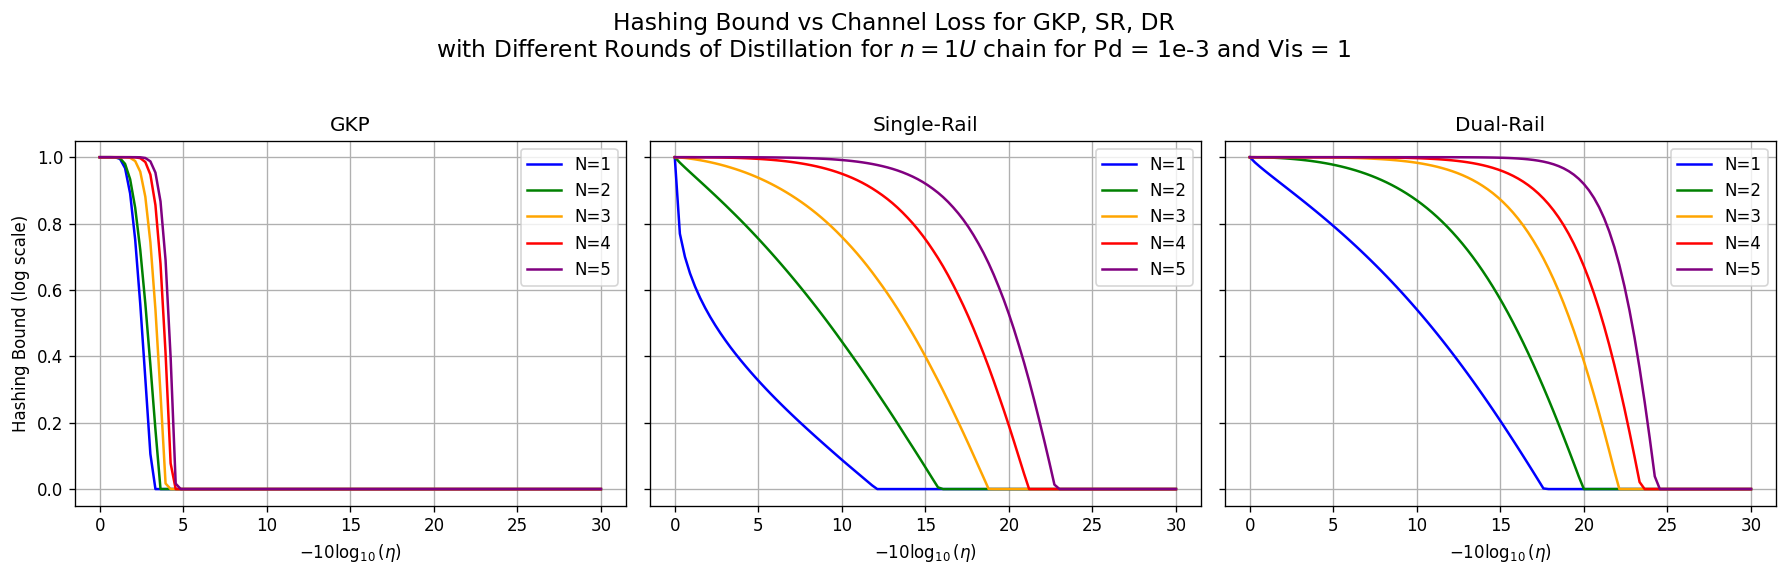

In [95]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=120, sharex=True, sharey=True)
titles = ['GKP', 'Single-Rail', 'Dual-Rail']
all_bounds = [boundsGKP1, boundsSR1, boundsDR1]
colors = ['blue', 'green', 'orange', 'red' , 'purple']
#  , 'brown' , 'pink' , 'gray' , 'olive' , 'cyan' , 'teal' , 'navy' , 'gold' , 'coral' , 'darkgreen'
dB = -10 * np.log10(etas)
Ns = [1, 2, 3, 4 , 5]

for ax, bounds, title in zip(axs, all_bounds, titles):
    # ax.set_yscale("log")
    for i, N in enumerate(Ns):
        ax.plot(dB, bounds[i], label=f"N={N}", color=colors[i])
    ax.set_title(title)
    ax.set_xlabel(r"$-10\log_{10}(\eta)$")
    ax.grid(True)
    ax.legend()

axs[0].set_ylabel("Hashing Bound (log scale)")

fig.suptitle("Hashing Bound vs Channel Loss for GKP, SR, DR\nwith Different Rounds of Distillation for $n=1U$ chain for Pd = 1e-3 and Vis = 1", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [73]:

sigma1 = np.sqrt(0.01)
n = 4
etas = np.linspace(0.01 , 1.0 , 100)

# Precompute all bounds
boundsGKP4 = [
    [optimal_hashing_bound(sigma1, eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]

boundsSR4 = [
    [optimal_SRhashingbound(eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]

boundsDR4 = [
    [DR_hashing_bound(eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]

/Users/conallcampbell/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2307: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/Users/conallcampbell/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2308: RuntimeWarning: invalid value encountered in scalar subtract
  q = 2.0 * (q - r)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_61959/178726765.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)


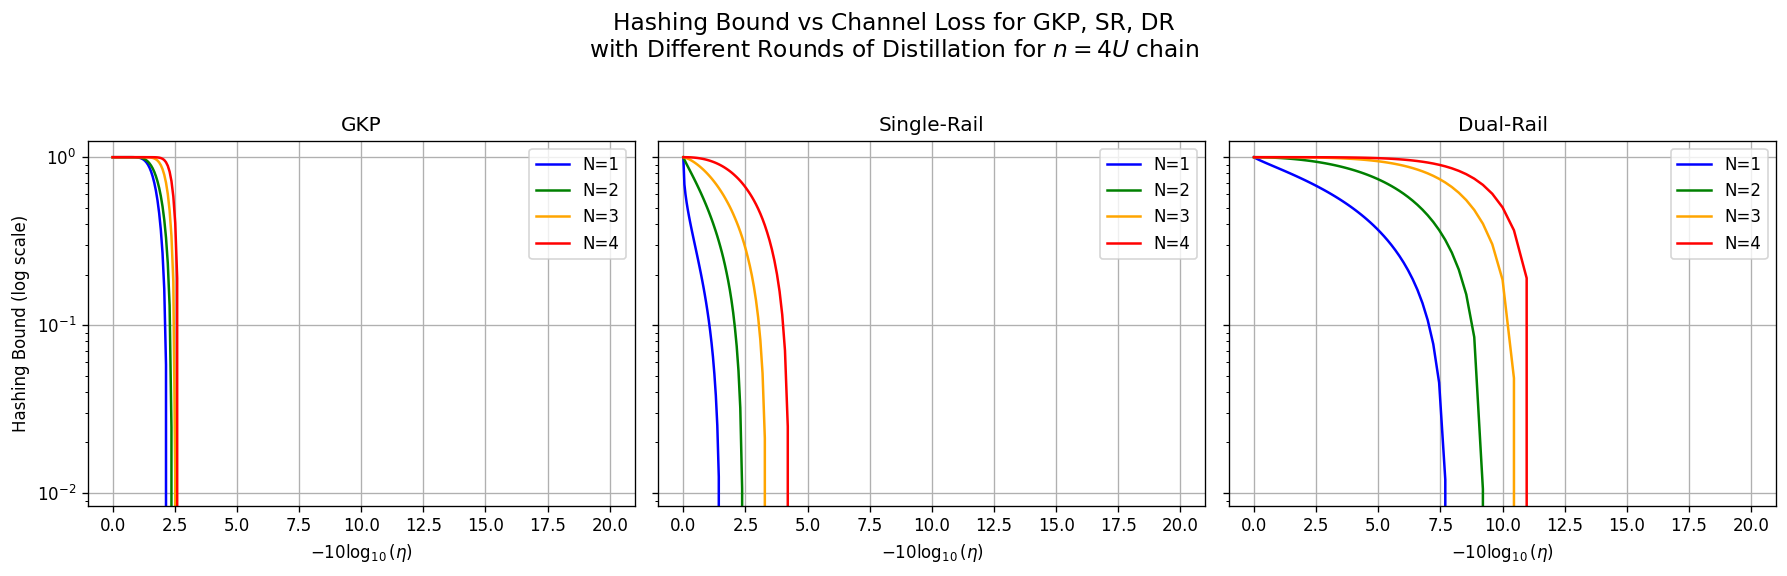

In [74]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=120, sharex=True, sharey=True)
titles = ['GKP', 'Single-Rail', 'Dual-Rail']
all_bounds = [boundsGKP4, boundsSR4, boundsDR4]
colors = ['blue', 'green', 'orange', 'red']
Ns = [1, 2, 3, 4]

for ax, bounds, title in zip(axs, all_bounds, titles):
    ax.set_yscale("log")
    for i, N in enumerate(Ns):
        ax.plot(dB, bounds[i], label=f"N={N}", color=colors[i])
    ax.set_title(title)
    ax.set_xlabel(r"$-10\log_{10}(\eta)$")
    ax.grid(True)
    ax.legend()

axs[0].set_ylabel("Hashing Bound (log scale)")

fig.suptitle("Hashing Bound vs Channel Loss for GKP, SR, DR\nwith Different Rounds of Distillation for $n=4U$ chain", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [75]:

sigma1 = np.sqrt(0.01)
n = 10
etas = np.linspace(0.01 , 1.0 , 100)

# Precompute all bounds
boundsGKP10 = [
    [optimal_hashing_bound(sigma1, eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]

boundsSR10 = [
    [optimal_SRhashingbound(eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]

boundsDR10 = [
    [DR_hashing_bound(eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]

/Users/conallcampbell/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2307: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/Users/conallcampbell/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2308: RuntimeWarning: invalid value encountered in scalar subtract
  q = 2.0 * (q - r)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_61959/178726765.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)


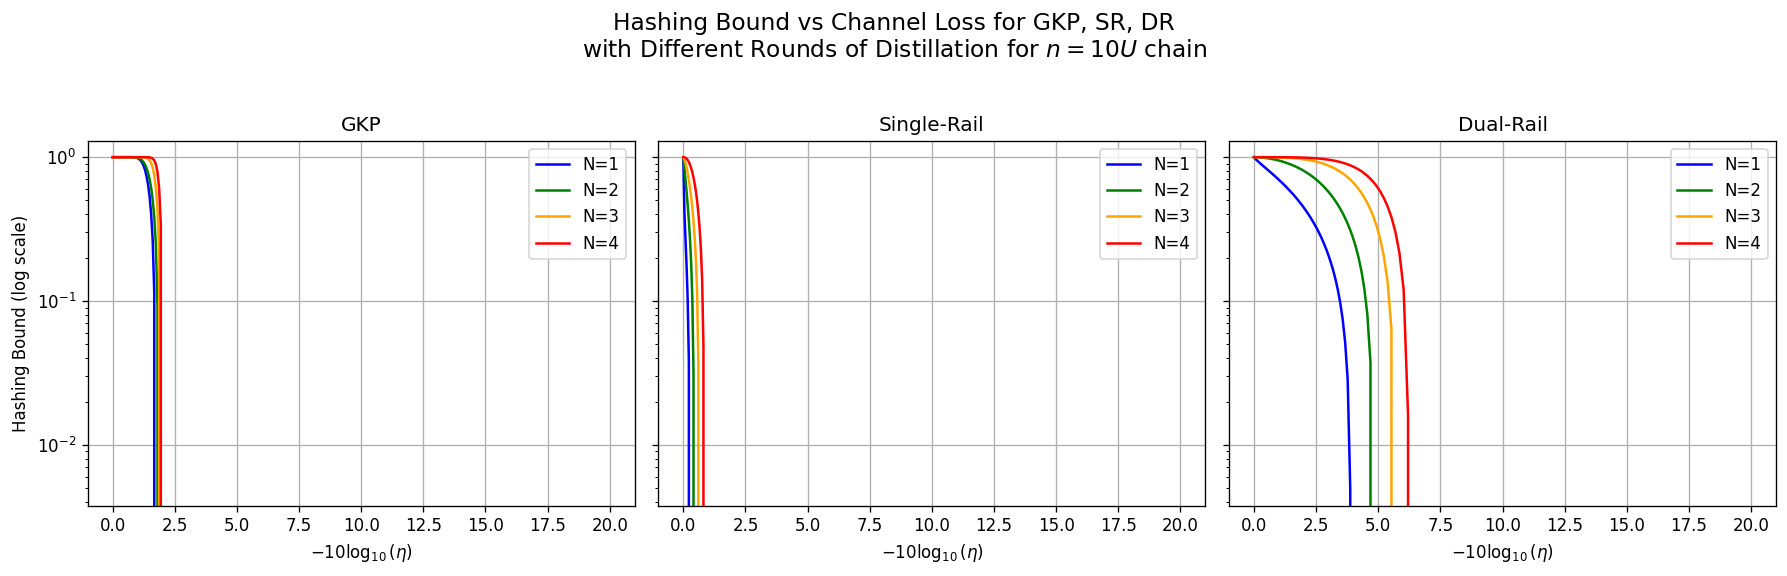

In [76]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=120, sharex=True, sharey=True)
titles = ['GKP', 'Single-Rail', 'Dual-Rail']
all_bounds = [boundsGKP10, boundsSR10, boundsDR10]
colors = ['blue', 'green', 'orange', 'red']
Ns = [1, 2, 3, 4]

for ax, bounds, title in zip(axs, all_bounds, titles):
    ax.set_yscale("log")
    for i, N in enumerate(Ns):
        ax.plot(dB, bounds[i], label=f"N={N}", color=colors[i])
    ax.set_title(title)
    ax.set_xlabel(r"$-10\log_{10}(\eta)$")
    ax.grid(True)
    ax.legend()

axs[0].set_ylabel("Hashing Bound (log scale)")

fig.suptitle("Hashing Bound vs Channel Loss for GKP, SR, DR\nwith Different Rounds of Distillation for $n=10U$ chain", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [77]:

sigma1 = np.sqrt(0.01)
n = 50
etas = np.linspace(0.01 , 1.0 , 100)

# Precompute all bounds
boundsGKP50 = [
    [optimal_hashing_bound(sigma1, eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]

boundsSR50 = [
    [optimal_SRhashingbound(eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]

boundsDR50 = [
    [DR_hashing_bound(eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]

/Users/conallcampbell/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2307: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/Users/conallcampbell/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2308: RuntimeWarning: invalid value encountered in scalar subtract
  q = 2.0 * (q - r)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_61959/178726765.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)


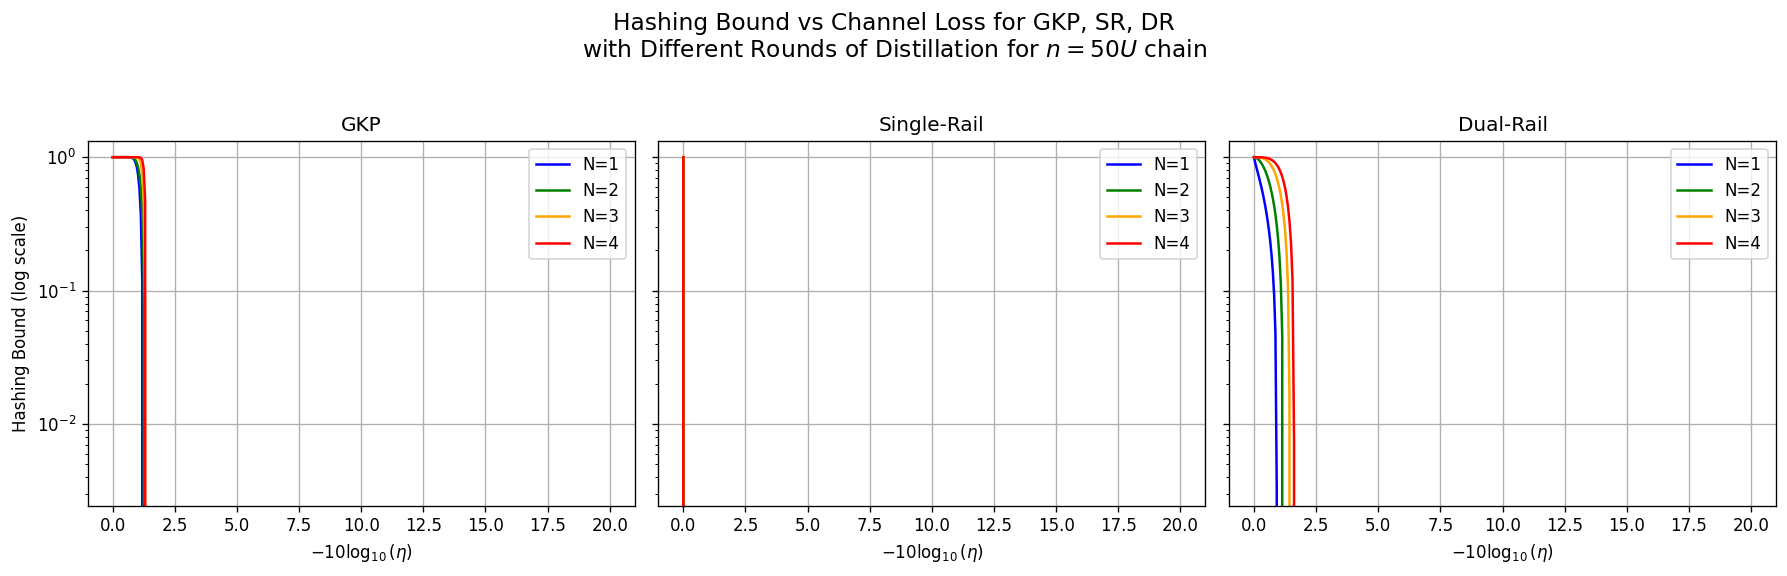

In [78]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=120, sharex=True, sharey=True)
titles = ['GKP', 'Single-Rail', 'Dual-Rail']
all_bounds = [boundsGKP50, boundsSR50, boundsDR50]
colors = ['blue', 'green', 'orange', 'red']
Ns = [1, 2, 3, 4]

for ax, bounds, title in zip(axs, all_bounds, titles):
    ax.set_yscale("log")
    for i, N in enumerate(Ns):
        ax.plot(dB, bounds[i], label=f"N={N}", color=colors[i])
    ax.set_title(title)
    ax.set_xlabel(r"$-10\log_{10}(\eta)$")
    ax.grid(True)
    ax.legend()

axs[0].set_ylabel("Hashing Bound (log scale)")

fig.suptitle("Hashing Bound vs Channel Loss for GKP, SR, DR\nwith Different Rounds of Distillation for $n=50U$ chain", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [79]:

sigma1 = np.sqrt(0.01)
n = 100
etas = np.linspace(0.01 , 1.0 , 100)

# Precompute all bounds
boundsGKP100 = [
    [optimal_hashing_bound(sigma1, eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]

boundsSR100 = [
    [optimal_SRhashingbound(eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]

boundsDR100 = [
    [DR_hashing_bound(eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_61959/178726765.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)


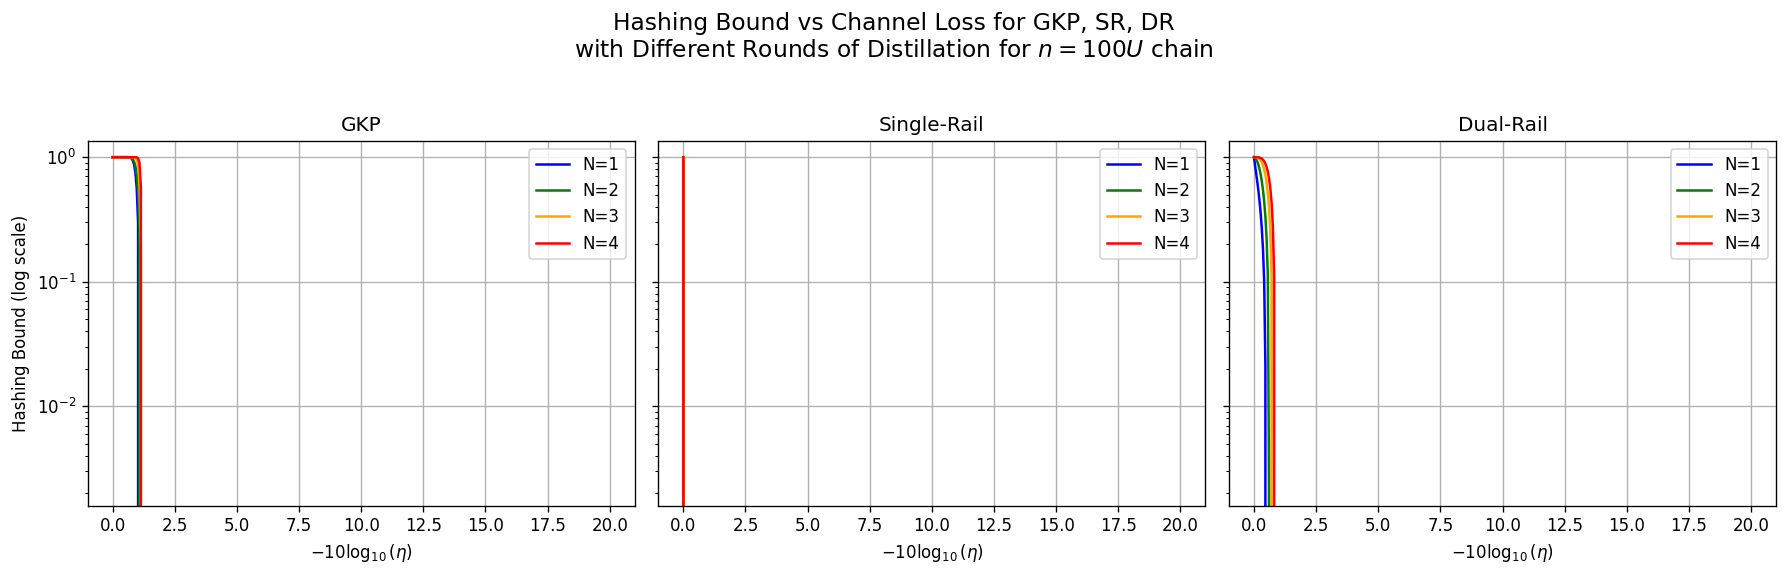

In [80]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=120, sharex=True, sharey=True)
titles = ['GKP', 'Single-Rail', 'Dual-Rail']
all_bounds = [boundsGKP100, boundsSR100, boundsDR100]
colors = ['blue', 'green', 'orange', 'red']
Ns = [1, 2, 3, 4]

for ax, bounds, title in zip(axs, all_bounds, titles):
    ax.set_yscale("log")
    for i, N in enumerate(Ns):
        ax.plot(dB, bounds[i], label=f"N={N}", color=colors[i])
    ax.set_title(title)
    ax.set_xlabel(r"$-10\log_{10}(\eta)$")
    ax.grid(True)
    ax.legend()

axs[0].set_ylabel("Hashing Bound (log scale)")

fig.suptitle("Hashing Bound vs Channel Loss for GKP, SR, DR\nwith Different Rounds of Distillation for $n=100U$ chain", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [81]:

sigma1 = np.sqrt(0.01)
n = 200
etas = np.linspace(0.01 , 1.0 , 100)

# Precompute all bounds
boundsGKP200 = [
    [optimal_hashing_bound(sigma1, eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]

boundsSR200 = [
    [optimal_SRhashingbound(eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]

boundsDR200 = [
    [DR_hashing_bound(eta, n, N) for eta in etas]
    for N in [1, 2, 3, 4]
]

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_61959/178726765.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)
Distillation failed at round 1 (zero or invalid)


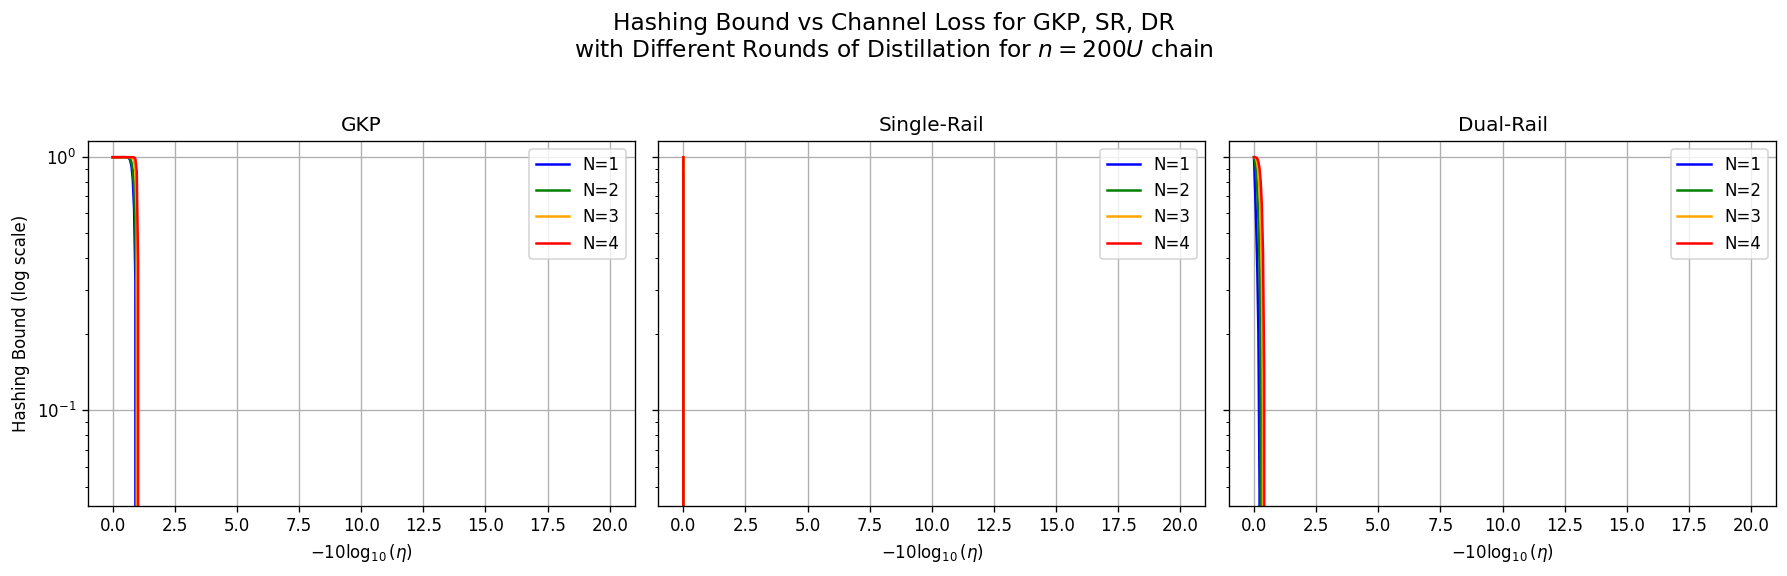

In [82]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=120, sharex=True, sharey=True)
titles = ['GKP', 'Single-Rail', 'Dual-Rail']
all_bounds = [boundsGKP200, boundsSR200, boundsDR200]
colors = ['blue', 'green', 'orange', 'red']
Ns = [1, 2, 3, 4]

for ax, bounds, title in zip(axs, all_bounds, titles):
    ax.set_yscale("log")
    for i, N in enumerate(Ns):
        ax.plot(dB, bounds[i], label=f"N={N}", color=colors[i])
    ax.set_title(title)
    ax.set_xlabel(r"$-10\log_{10}(\eta)$")
    ax.grid(True)
    ax.legend()

axs[0].set_ylabel("Hashing Bound (log scale)")

fig.suptitle("Hashing Bound vs Channel Loss for GKP, SR, DR\nwith Different Rounds of Distillation for $n=200U$ chain", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()